# Identifying suitable sites for new ALS clinics using location allocation analysis

## Clinic access for the chronically ill

Location is everything for the chronically ill.  For patients with amyotrophic lateral sclerosis (ALS), visits to clinics are exhausting full-day engagements involving sessions with highly trained specialists from several disciplines.  Patients with long drives to their nearest clinic may also face the additional hardship of having to plan for travel days to and from the clinic as well as for food and lodging.  

This notebook demonstrates how ArcGIS can perform network analysis to identify potential sites for new ALS clinics in California to improve access for patients who do not live near a clinic.

<blockquote><b>Note:</b> The examples in this notebook is intended to serve only as a technology demonstration.  The analysis results should not be used for any planning purposes as the data for ALS patient locations are fictional.  The ALS clinic locations were obtained from data that was publically available in October 2017.</blockquote>

## Access the analysis data

In [ ]:
# Import the ArcGIS API for Python
from arcgis import *
from IPython.display import display

# Connect to the web GIS.
gis = GIS('https://python.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

In [ ]:
# Search for content tagged with 'ALS'
search_als = gis.content.search('tags: ALS', 'Feature Layer')
for item in search_als:
    display(item)

## Map the challenge

Many ALS patients in California have to drive for over 90 minutes to reach their nearest clinic.  For the purposes of this notebook, those patients are considered to have poor clinic access. The next block of code displays a map that displays the locations of those ALS patients who have poor clinic access.  

Map Legend:

<p><img src="http://esri.github.io/arcgis-python-api/notebooks/nbimages/04_als_patients.png" style="float:left">Locations of ALS patients that must travel for over 90 minutes to access a clinic.
<p><img src="http://esri.github.io/arcgis-python-api/notebooks/nbimages/04_als_clinics.png" style="float:left">Existing ALS clinics.
<p><img src="http://esri.github.io/arcgis-python-api/notebooks/nbimages/04_als_drive_times.png" style="float:left">90 minute drive times from existing ALS clinics.
<p><img src="http://esri.github.io/arcgis-python-api/notebooks/nbimages/04_als_candidate_clinics2.png" style="float:left">Candidate cities for new ALS clinics.

In [ ]:
# Display the titles of the items returned by the search.
for item in search_als:
    print(item.title)


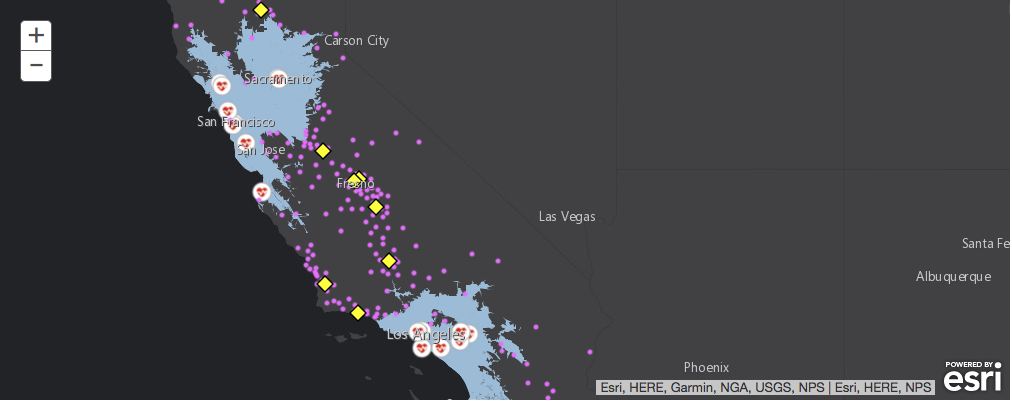

In [2]:
# Create a map of California.
map1 = gis.map("State of California, USA")
map1.basemap = 'dark-gray'
display(map1)

In [ ]:
# Add the ALS content to the map.
for item in search_als:
    if item.title == 'ALS_Clinics_CA':
        als_clinics = item       
    if item.title == 'ALS_Patients_CA':
        patient_locations = item        
    if item.title == 'ALS_Clinic_City_Candidates_CA':
        city_candidates = item    
    elif item.title == 'ALS_Clinic_90minDriveTime_CA':
        drive_times = item
        
map1.add_layer(drive_times)
map1.add_layer(als_clinics)
map1.add_layer(patient_locations)
map1.add_layer(city_candidates)

## Introduction to Location-Allocation
### ArcGIS Network Analyst

[ArcGIS Network Analyst](http://pro.arcgis.com/en/pro-app/help/analysis/networks/what-is-network-analyst-.htm) helps organizations run their operations more efficiently and improve strategic decision making by performing analysis on the travel costs between their facilities and demand locations to answer questions such as:

* What is the quickest way to get from point A to point B?
* What houses are within five minutes of our fire stations?
* What markets do our businesses cover?
* Where should we open a new branch of our business to maximize market share?

To address these questions, ArcGIS Network Analyst creates origin-destination (OD) cost matrices along a travel network such as roads, to find solutions to reduce the overall costs of travel.

![title](http://esri.github.io/arcgis-python-api/notebooks/nbimages/04_als_odcost.png)

To perform network analysis, you need a network dataset, which models a transportation network.  In the ArcGIS API for Python, the network dataset is accessed through a network service hosted in ArcGIS Online or Portal for ArcGIS.

### Location-Allocation Analysis

The goal of [location-allocation](http://pro.arcgis.com/en/pro-app/help/analysis/networks/location-allocation-analysis-layer.htm) is to locate facilities in a way that supplies the demand points most efficiently.  As the name suggests, location-allocation is a two-fold problem that simultaneously locates facilities and allocates demand points to the facilities.

![title](http://esri.github.io/arcgis-python-api/notebooks/nbimages/04_als_location_allocation_schematic.png)

### The `solve_location_allocation` tool

In this notebook, we will use the [solve_location_allocation](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.network.analysis.html#solve-location-allocation) tool to find the best locations for new ALS clinics in California.  Inputs to this tool include [FeatureSet](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featureset)s containing the following data:
* facilities
* demand points.  

For the examples in this notebook, the facilities are a set of candidate locations for new ALS clinics.  These locations could be actual addresses.  However, for these examples, the candidate locations are cities that could potentially host new ALS clinics and are represented by their centroid points. The candidate cities were pre-selected based on the following criteria:
* they are within California
* they are outside of the 90 minute drive time areas from existing ALS clinics
* they have populations of at least 60,000, and are therefore assumed to have sufficient health care facilities and professionals to support an ALS clinic

The analyses in this notebook could lead to further multi-criteria analysis to identify specific  locations within a city or other geographic area.  For examples of Jupyter Notebooks with multi-criteria suitability analysis see [Calculating cost surfaces using weighted overlay analysis](https://developers.arcgis.com/python/sample-notebooks/calculating-cost-surfaces-using-weighted-overlay-analysis/) and [Finding suitable spots for placing heart defibrillator equipments in public](https://developers.arcgis.com/python/sample-notebooks/finding-suitable-spots-for-aed-devices-using-raster-analytics/)

For the demand points, we will use point locations of fictional ALS patients.  These locations are aggregated to zip code centroids and contain an estimated number of ALS patients based on the total population within each zip code.

The output of the tool is a named tuple which contains the following data:
* solve_succeeded (`bool`)
* output_facilities (`FeatureSet`)
* output_demand_points (`FeatureSet`)
* output_allocation_lines (`FeatureSet`)

To prepare to run the `solve_location_allocation` tool we will first perform the following steps:
1. Extract the required input `FeatureSets` for the tool from `FeatureLayerCollection` items in the GIS.
2. Define a function to extract, symbolize, and display the output results from the `solve_location_allocation` tool.

## Analysis Preparation

In [ ]:
# Extract the required input data for the analyses.

# ALS clinic city candidates FeatureSet
city_candidates_fset = city_candidates.layers[0].query()

# ALS patient locations FeatureSet
patient_locations_fset = patient_locations.layers[0].query()

# Display the ALS patients FeatureSet in a pandas Dataframe
patient_locations_sdf = patient_locations_fset.sdf
patient_locations_sdf.head()

Note that the `num_patients` field contains the numbers of ALS patients at each location. We can use the `num_patients` field to "weight" the analysis in favor of candidate cities with the greatest numbers of patients near them.

To accomplish this, add a column called `weight` to the `SpatialDataFrame` object and remove the old `num_patients` column.

In [ ]:
# create the 'weight' column
patient_locations_sdf['weight'] = patient_locations_sdf['num_patients']

# drop the 'num_patients' column
patient_locations_sdf2 = patient_locations_sdf.drop('num_patients', axis=1)

# convert SpatialDataFrame back to a FeatureSet
patient_locations_weighted = patient_locations_sdf2.spatial.to_featureset()
patient_locations_weighted.sdf.head()

In [ ]:
# Define a function to display the output analysis results in a map
import time

def visualize_locate_allocate_results(map_widget, solve_locate_allocate_result, zoom_level):
    # The map widget
    m = map_widget
    # The locate-allocate analysis result
    result = solve_locate_allocate_result
    
    # 1. Parse the locate-allocate analysis results
    # Extract the output data from the analysis results
    # Store the output points and lines in pandas dataframes
    demand_df = result.output_demand_points.sdf
    lines_df = result.output_allocation_lines.sdf

    # Extract the allocated demand points (patients) data.
    demand_allocated_df = demand_df[demand_df['DemandOID'].isin(lines_df['DemandOID'])]
    demand_allocated_fset = features.FeatureSet.from_dataframe(demand_allocated_df)

    # Extract the un-allocated demand points (patients) data.
    demand_not_allocated_df = demand_df[~demand_df['DemandOID'].isin(lines_df['DemandOID'])]
    demand_not_allocated_fset = features.FeatureSet.from_dataframe(demand_not_allocated_df)

    # Extract the chosen facilities (candidate clinic sites) data.
    facilities_df = result.output_facilities.sdf[['Name', 'FacilityType', 
                                                 'Weight','DemandCount', 'DemandWeight', 'SHAPE']]
    facilities_chosen_df = facilities_df[facilities_df['FacilityType'] == 3]
    facilities_chosen_fset = features.FeatureSet.from_dataframe(facilities_chosen_df)

    # 2. Define the map symbology
    # Allocation lines
    allocation_line_symbol_1 = {'type': 'esriSLS', 'style': 'esriSLSSolid',
                                'color': [255,255,255,153], 'width': 0.7}

    allocation_line_symbol_2 = {'type': 'esriSLS', 'style': 'esriSLSSolid',
                                'color': [0,255,197,39], 'width': 3}

    allocation_line_symbol_3 = {'type': 'esriSLS', 'style': 'esriSLSSolid',
                                'color': [0,197,255,39], 'width': 5}
    
    allocation_line_symbol_4 = {'type': 'esriSLS', 'style': 'esriSLSSolid',
                                'color': [0,92,230,39], 'width': 7}
    
    # Patient points within 90 minutes drive time to a proposed clinic location.
    allocated_demand_symbol = {'type' : 'esriPMS', 'url' : 'https://maps.esri.com/legends/Firefly/cool/1.png',
                               'contentType' : 'image/png', 'width' : 26, 'height' : 26,
                               'angle' : 0, 'xoffset' : 0, 'yoffset' : 0}

    # Patient points outside of a 90 minutes drive time to a proposed clinic location.
    unallocated_demand_symbol = {'type' : 'esriPMS', 'url' : 'https://maps.esri.com/legends/Firefly/warm/1.png',
                                 'contentType' : 'image/png', 'width' : 19.5, 'height' : 19.5,
                                 'angle' : 0, 'xoffset' : 0, 'yoffset' : 0}

    # Selected clinic
    selected_facilities_symbol = {'type' : 'esriPMS', 'url' : 'https://maps.esri.com/legends/Firefly/ClinicSites.png',
                                  'contentType' : 'image/png', 'width' : 26, 'height' : 26,
                                  'angle' : 0, 'xoffset' : 0, 'yoffset' : 0}   
    
    # 3. Display the analysis results in the map
    # Add a slight delay for drama. 
    time.sleep(1.5)  
    # Display the patient-clinic allocation lines.
    m.draw(shape=result.output_allocation_lines, symbol=allocation_line_symbol_4)
    m.draw(shape=result.output_allocation_lines, symbol=allocation_line_symbol_2)
    m.draw(shape=result.output_allocation_lines, symbol=allocation_line_symbol_1)
 
    # Display the locations of patients within the specified drive time to the selected clinic(s).
    m.draw(shape=demand_allocated_fset, symbol=allocated_demand_symbol)

    # Display the locations of patients outside the specified drive time to the selected clinic(s).
    m.draw(shape = demand_not_allocated_fset, symbol = unallocated_demand_symbol)

    # Display the chosen clinic site.
    m.draw(shape=facilities_chosen_fset, symbol=selected_facilities_symbol)

    # Zoom out to display all of the allocated patients points.
    m.zoom = zoom_level

## Analysis: Where could we add one new ALS clinic to reach the greatest number of ALS patients who currently have poor access to an existing clinic?

To answer this question, we will use the **"Maximize Coverage"** problem type.  This problem type chooses facilities such that as many demand points as possible are allocated to facilities within the impedance cutoff.  In this example, the impedance cutoff is defined as a drive time of 90 minutes.

In [ ]:
# Identify the city which has the greatest number of patients within a 90 minute drive time.
result1 = network.analysis.solve_location_allocation(problem_type='Maximize Coverage',
    travel_direction='Demand to Facility',
    number_of_facilities_to_find='1',
    demand_points=patient_locations_weighted,
    facilities=city_candidates_fset,
    measurement_units='Minutes',
    default_measurement_cutoff=90
)
print('Analysis succeeded? {}'.format(result1.solve_succeeded))

In [ ]:
# Display the analysis results in a pandas dataframe.
result1.output_facilities.sdf[['Name', 'FacilityType', 'DemandCount', 'DemandWeight']]

The selected facility, i.e. ALS city candidate, is assigned the value "3" in the `FacilityType` field.  The `DemandCount` and `DemandWeight` fields indicate the number of demand points (patient locations) and total number of patients at those locations which are allocated to the facility.

Now, let us visualize the results on a map.


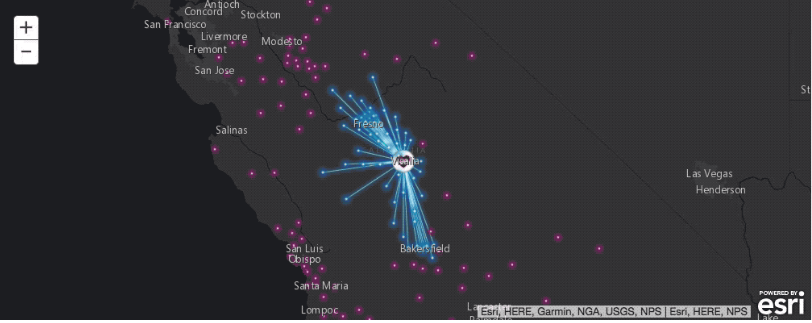

In [3]:
# Display the analysis results in a map.

# Create a map of Visalia, California.
map2 = gis.map('Visalia, CA')
map2.basemap = 'dark-gray'
display(map2)

# Call custom function defined earlier in this notebook to 
# display the analysis results in the map.
visualize_locate_allocate_results(map2, result1, zoom_level=7)

## Analysis: Where could we add new ALS clinics to reach 50% of patients who currently must drive for over 90 minutes to reach their nearest clinic?

To answer this question we will use the **"Target Market Share"** problem type.  This problem type chooses the minimum number of facilities necessary to capture a specific percentage of the total market share.

In [ ]:
# Identify where to open new clinics that are within a 90 minute drive time
# of 50% of ALS patients who currently have to drive for over 90 minutes to reach their nearest clinic.

result2 = network.analysis.solve_location_allocation(
    problem_type='Target Market Share', 
    target_market_share=70,
    facilities=city_candidates_fset, 
    demand_points=patient_locations_weighted,
    travel_direction='Demand to Facility',
    measurement_units='Minutes', 
    default_measurement_cutoff=90
)

print('Solve succeeded? {}'.format(result2.solve_succeeded))

In [ ]:
# Display the analysis results in a table.
result2.output_facilities.sdf[['Name', 'FacilityType', 'DemandCount', 'DemandWeight']]

The `solve_location_allocation` tool selected two of the candidate cities to host new ALS clinics. If ALS clinics are established in both of those cities, 50% of the patients who must currently drive for over 90 minutes to reach an existing clinic would be able to access one of the new clinics in 90 minutes or less.

Now, let us visualize the results on a map.


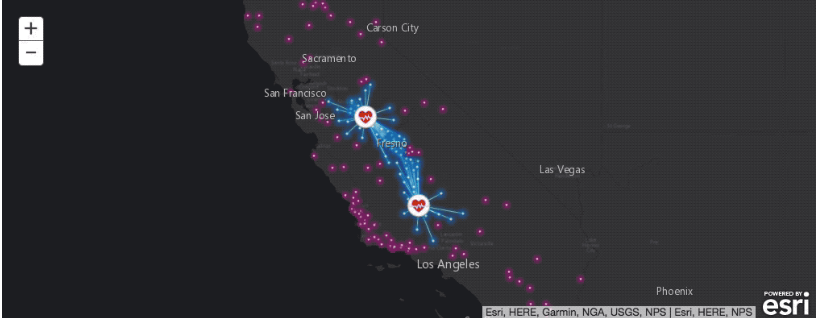

In [4]:
# Display the analysis results in a map.

# Create a map of Visalia, California
map3 = gis.map('Visalia, CA', zoomlevel=7)
map3.basemap = 'dark-gray'

# Display the map and add the analysis results to it
from IPython.display import display
display(map3)
visualize_locate_allocate_results(map3, result2, zoom_level=6)

# Conclusions

The ArcGIS Network Analysis toolset is a versatile set of tools that assist strategic decision making to reduce the costs of travel.  This examples in this notebook only scratch the surface of the situations where you could use these tools.  By performing your analysis using Python and the Jupyter Notebook, you also document your methodology in a form that can be easily shared via email to colleagues and stake holders, enabling them to reproduce your results or repeat the analyses in an iterative fashion with different parameters or different input datasets.  You can also [export](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html) the output tables from the solve_location_allocation tool by to CSV files to share with stake holders via email.